# BBC News Article Subject Mining

## Background
In this project I use non-negative matrix factorization to try to predict what the topics of a sample of BBC news articles are.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.ticker as ticker
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from collections import Counter
from sklearn.decomposition import NMF
import itertools

## Loading Train and Test Data and EDA

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
train = pd.read_csv('/content/gdrive/Othercomputers/My Laptop/Python/BBC News Train.csv')
test = pd.read_csv('/content/gdrive/Othercomputers/My Laptop/Python/BBC News Test.csv')

I will start by looking at the data. We can see the three variables - ArticleID, Text, and Category - and that there are 1490 training observations.

In [4]:
train.head

<bound method NDFrame.head of       ArticleId                                               Text  \
0          1833  worldcom ex-boss launches defence lawyers defe...   
1           154  german business confidence slides german busin...   
2          1101  bbc poll indicates economic gloom citizens in ...   
3          1976  lifestyle  governs mobile choice  faster  bett...   
4           917  enron bosses in $168m payout eighteen former e...   
...         ...                                                ...   
1485        857  double eviction from big brother model caprice...   
1486        325  dj double act revamp chart show dj duo jk and ...   
1487       1590  weak dollar hits reuters revenues at media gro...   
1488       1587  apple ipod family expands market apple has exp...   
1489        538  santy worm makes unwelcome visit thousands of ...   

           Category  
0          business  
1          business  
2          business  
3              tech  
4          business

Next I want to get an idea of how many articles are in each category. If there is a major imbalance, then I might need to balance the articles. 

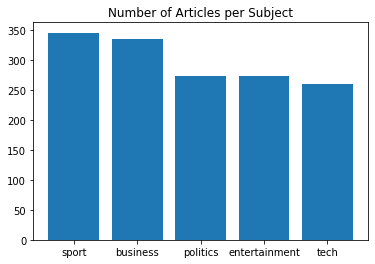

In [5]:
categories = train['Category'].value_counts().index
count = train['Category'].value_counts().values
plt.bar(categories, count)
plt.title('Number of Articles per Subject');

In [6]:
train['Category'].value_counts()

sport            346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64

We can see from the bar graph, that sports is the most common category, closely followed by business. Tech is the least common category, with only a bit over 250 articles in the training set. The imbalance, however, does not appear so great that it needs to be corrected for. 

Next I will look at the numbers of words in each article. On average the articles have 385 words, but the distribution is right-skewed, and there are a fw very long articles with more than 1500 words. 

In [7]:
word_counts = []
for i in train['Text'].str.split():
  word_counts.append(len(i))

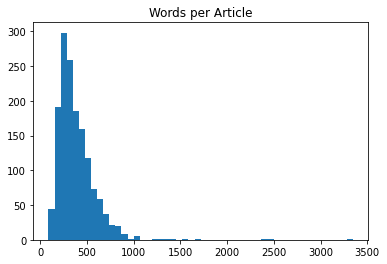

In [8]:
plt.hist(word_counts, bins = 50)
plt.title('Words per Article');

In [9]:
np.mean(word_counts)

385.01275167785235

It would be nice to see how this varies by category, so next I do some summary statistics, breaking down each category of news article in the training set.

In [10]:
#find average length by category
topics = ['business','politics','sport','entertainment','tech']

#create a dictionary of article lengths and their category
lengths = pd.DataFrame({'Word Length':word_counts,'Topic':train['Category']})

means = [np.mean(lengths[lengths['Topic'] == t]['Word Length']) for t in topics]
medians = [np.median(lengths[lengths['Topic'] == t]['Word Length']) for t in topics]
mins = [min(lengths[lengths['Topic'] == t]['Word Length']) for t in topics]
maxs = [max(lengths[lengths['Topic'] == t]['Word Length']) for t in topics]
stdevs = [np.std(lengths[lengths['Topic'] == t]['Word Length']) for t in topics]

pd.DataFrame({'Average Word Count':means,'Median Word Count':medians,'Fewest Words in Article':mins,'Most Words in Article':maxs,'SD':stdevs}, index = [topics])


,Average Word Count,Median Word Count,Fewest Words in Article,Most Words in Article,SD
business,334.169643,304.0,145,902,133.328422
politics,449.689781,441.5,90,3345,258.363481
sport,335.346821,294.5,116,1671,185.174909
entertainment,333.912088,272.0,144,2448,203.513586
tech,501.858238,457.0,188,1549,211.267093


We can see that the average words lengths for the different topics are quite different. Technology articles tend to be around 165 words longer than sports articles. Politics articles tend to have the greatest spread in their distribution.  

Another thing I am curious to check is the vocabulary complexity of the different types of articles. A simple measure of vocabulary complexty is the proportion of unique words that an articles uses. First I want to see how many unique words are in the entire training set.

In [11]:
article = train['Text'].str.split()
words = [word for a in article for word in a]

corpus = set(words)
len(corpus)

35594

Now I measure the vocabulary complexity of each article. A high score indicates a richer vocabulary was used. A score of 1, for example, would mean that every single word in the article was unique, while a score of $\frac{1}{n}$ where $n$ is the article length is the lowest possible score and means that the article consisted of just one word repeated over and over. 

In [12]:
complexity_score = []
highest_so_far = 0
most_complex_article = []

for article in train['Text']:
    w = set()
    for word in article:
        w.add(word)
    complexity = len(w)/len(article)
    complexity_score.append(complexity)
    if complexity > highest_so_far:
        highest_so_far = complexity
        most_complex_article = article

As we could have expected, the most complex article is actually fairly short:

In [13]:
print(highest_so_far)
most_complex_article

0.05788423153692615


'blunkett hints at election call ex-home secretary david blunkett has given fresh clues that the general election will be announced on monday.  he told bbc radio five live:  i m out in my constituency getting ready for what we presume will be an announcement very shortly at the weekend.  he clarified that he meant he would be in his sheffield seat this weekend  not that he expected an election call then. tony blair is tipped to ask the queen on monday to dissolve parliament ready for a 5 may poll.'

In [14]:
topics = ['business','politics','sport','entertainment','tech']
means = [np.mean(train[train['Category'] == i]['Text'].str.len()) for i in topics]

In [15]:
c = pd.concat([train['Category'],pd.Series(complexity_score)], axis = 1)
c.columns = ['Category','Complexity']

c.groupby('Category')['Complexity'].mean()

Category
business         0.022493
entertainment    0.022099
politics         0.015494
sport            0.022454
tech             0.014267
Name: Complexity, dtype: float64

There is actually not an interesting difference in complexity by topic. The three topics with shorter articles tend to have higher and roughly identical vocabulary complexity, while the longest genres have lower but similar complexity.

### Vectorization

This is enough EDA for now. I have some sense of the data, and it appears to be very clean, so no additional cleaning is required. The next task is to embed the words in the training set into a word vector. I will first use a Count Vectorizer because this makes it easy to get counts of the word frequencies. I display two plots - the most common single words, and the most common triplets, or tri-grams (excluding stop words).


In [16]:
# Make count vectorizer object and fit it to the text; then transform the text into the vectorized form
count_vec = CountVectorizer(ngram_range=(1, 1), stop_words='english').fit(train['Text'])
bag_of_words = count_vec.transform(train['Text'])

#Get the frequency of each word.
total = bag_of_words.sum(axis=0) 
total

matrix([[  4, 553,   1, ...,   7,   1,   4]])

In [17]:
frequencies = [(word, total[0, i]) for word, i in count_vec.vocabulary_.items()]
frequencies =sorted(frequencies, key = lambda x: x[1], reverse=True)
print(frequencies[:20])


[('said', 4839), ('mr', 1974), ('year', 1528), ('new', 1338), ('people', 1324), ('time', 882), ('world', 805), ('uk', 781), ('government', 752), ('film', 646), ('years', 644), ('best', 642), ('just', 636), ('make', 613), ('told', 591), ('game', 570), ('000', 553), ('like', 547), ('number', 528), ('labour', 516)]


We can see that "said" is the most common non-stop word. It is not too informative and as an outlier, it distorts the scale of the graph, so I will instead plot the next 20 most common words.

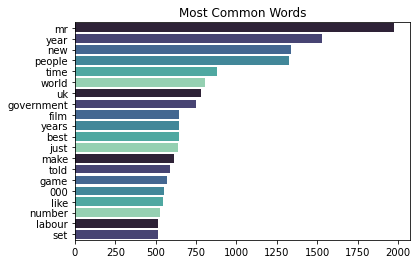

In [18]:
x,y=map(list,zip(*frequencies[1:21]))

p = sns.color_palette("mako")
sns.barplot(x=y,y=x, palette = p).set_title('Most Common Words');

The unigrams are not very informative. From experimenting, it seems that trigrams offer a bit more detail about the most commonly occuring topics. I plot them below.

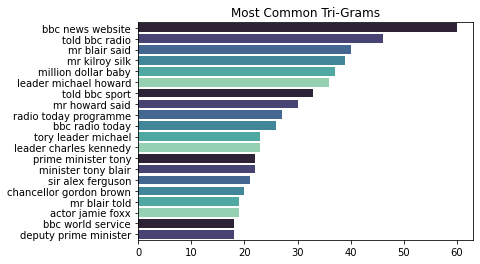

In [19]:
three_count_vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(train['Text'])
bag_of_words = three_count_vec.transform(train['Text'])
total = bag_of_words.sum(axis=0) 
frequencies = [(word, total[0, i]) for word, i in three_count_vec.vocabulary_.items()]
frequencies =sorted(frequencies, key = lambda x: x[1], reverse=True)
x,y=map(list,zip(*frequencies[1:21]))

p = sns.color_palette("mako")
sns.barplot(x=y,y=x, palette = p).set_title('Most Common Tri-Grams');

The 3-grams with stop words removed appear to come either from politics or entertainment articles.


## Building and Training the Model

For the model, I will be using a TF-IDF Vectorizer. A TF-IDF Vectorizer helps not only to model term frequency (TF), but also inverse document frequency(IDF), which divides the total number of articles by the articles containing the term - a measure of how many articles the term occurs in and how important it is for that category of news articles [1]. This provides a better measure of importance and allows me to exclude terms which are very frequent in a few articles, but are overall unimportant for the category. \

I exclude standard English stop words and will look at the top 1,000 most frequently occuring words or ngrams. This is an arbitrary choice, so later I will test whether choosing more or fewer words improves performance. I will set the ngram range up to three, so as to also embed any commonly occurring word pairs or triplets. From experimenting (not displayed here), I found that 4-grams were not very informative. It seems, *a priori*, that there will not be commonly occuring and informative ngrams of size five or greater. 


Now I fit the vectorizer on the training set text. The method I am following here comes from [Sci-Kit Learn's example](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html//) of topic modeling with non-negative matrix factorization [2].

In [20]:
# create a TF-IDF vectorizer object
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words="english", ngram_range=(1,3))

In [21]:
# fit it to the training text
tfidf = tfidf_vectorizer.fit_transform(train['Text'])

Let's look at the A matrix. It is a 1490 x 1000 sparse matrix, holding the normalized term frequency for each of the 1,000 words over the 1,490 articles. This is going to be the matrix that we decompose.

In [22]:
print("Shape of A matrix is: ",tfidf.A.shape)
tfidf.A

Shape of A matrix is:  (1490, 1000)


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.05380042, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.03361438, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.07578836, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.06414801, 0.        , ..., 0.04419795, 0.        ,
        0.        ],
       [0.04057545, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

Next I create an NMF object. I set components to be five, because there are five categories of news articles. Here I choose the loss function to be "kullback-leibler" and the solver to be multiplicative update ("mu"). I have no theoretical reason to choose these, and I will vary them later to see if different choices improve my results. I also set the regularization of W and H to be 0.1. Again, there is no theoretical reason for this, and this is something that could be changed with hyperparameter tuning. 

(Note: since I began this project, Python has begun to issue warnings for the code I had written before; I suppress all warnings here to make it more readable.)

In [23]:
import warnings
warnings.filterwarnings("ignore")

nmf = NMF(n_components=5, random_state=1, beta_loss="kullback-leibler", solver="mu", max_iter=1000, alpha_W=0.1, alpha_H = 0.1).fit(tfidf)

Now I use the NMF object to calculate the W and H matrices. The dimensions of the matrices appear to be right: 1490 x 5 and 5 x 1000, respectively. Their product would be 1490 x 1000.

In [24]:
W = nmf.fit_transform(tfidf)
print("Shape of W matrix is: ",W.shape)
W

Shape of W matrix is:  (1490, 5)


array([[0.09372711, 0.02522855, 0.        , 0.        , 0.        ],
       [0.11740429, 0.00582969, 0.        , 0.        , 0.        ],
       [0.10353528, 0.03905341, 0.        , 0.        , 0.        ],
       ...,
       [0.11530592, 0.        , 0.        , 0.        , 0.        ],
       [0.06437797, 0.        , 0.        , 0.        , 0.13406754],
       [0.02429919, 0.        , 0.        , 0.        , 0.11853242]])

In [25]:
H = nmf.components_
print("Shape of H matrix is: ",H.shape)
H

Shape of H matrix is:  (5, 1000)


array([[0.20228014, 0.16290489, 0.05675942, ..., 0.02489976, 0.03490023,
        0.01299383],
       [0.05280683, 0.        , 0.02369822, ..., 0.        , 0.10243618,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.05844227, 0.        ,
        0.06732658],
       [0.        , 0.        , 0.        , ..., 0.08495244, 0.        ,
        0.        ],
       [0.        , 0.        , 0.05175695, ..., 0.0142903 , 0.        ,
        0.        ]])

Now I am going to use the W matrix to generate predictions. For each article, I will choose the category which has the highest weight in the W matrix. I then compare these results with the known labels for the training set.

In [30]:
preds = pd.DataFrame(np.round(W,3))
preds['yhat'] = np.argmax(preds.values, axis = 1)
preds[:20]

,0,1,2,3,4,yhat
0,0.094,0.025,0.000,0.000,0.000,0
1,0.117,0.006,0.000,0.000,0.000,0
2,0.104,0.039,0.000,0.000,0.000,0
3,0.042,0.000,0.000,0.000,0.140,4
4,0.125,0.000,0.000,0.000,0.000,0
5,0.030,0.059,0.054,0.036,0.000,1
6,0.027,0.000,0.143,0.000,0.000,2
7,0.030,0.000,0.029,0.106,0.000,3
8,0.105,0.000,0.000,0.000,0.000,0
9,0.030,0.000,0.000,0.121,0.000,3


In [ ]:
train.head(20)

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
5,1582,howard truanted to play snooker conservative...,politics
6,651,wales silent on grand slam talk rhys williams ...,sport
7,1797,french honour for director parker british film...,entertainment
8,2034,car giant hit by mercedes slump a slump in pro...,business
9,1866,fockers fuel festive film chart comedy meet th...,entertainment


It looks successful! The categories line up nicely:\
Business: 0 \
Politics: 1 \
Sport: 2 \
Entertainment: 3 \
Tech: 4 \
\
Time to get overall accuracy for the training set and show the confusion matrix...

In [28]:
# Create a numeric version of the training labels
train_y = []
for i in train['Category']:
    if i == 'business':
        train_y.append(0)
    elif i == 'politics':
        train_y.append(1)
    elif i == 'sport':
        train_y.append(2)
    elif i == 'entertainment':
        train_y.append(3)
    elif i == 'tech':
        train_y.append(4)

In [31]:
print("Accuracy is: ", accuracy_score(train_y, preds['yhat']))
confusion_matrix(train_y, preds['yhat'])

Accuracy is:  0.897986577181208


array([[323,  10,   0,   0,   3],
       [ 25, 244,   0,   2,   3],
       [ 25,   0, 320,   1,   0],
       [ 43,   2,   1, 222,   5],
       [ 21,   6,   2,   3, 229]])

Overall, training accuracy is 89.8%. That is not bad, I think. The confusion matrix indicates that business articles were especially tricky for this method to correctly classify, with many business articles being incorrectly classified as one of the other categories, especially entertainment. \

### Hyperparameter Tuning
Before submitting to Kaggle to get the accuracy on the test set, I would like to try tuning some of the hyperparameters to see if that improves the training accuracy. Below I wrap the above steps up into a function to make automating the hyperparameter tuning easier. \

Some experimentation revealed that using the Frobenious loss function always yielded bad results (with accuracy stuck at approximate random chance levels, so I do not show results for tuning the loss function here). \

One difficulty is that the NMF method does not always choose the same label numbers. So the function also must check each permutation of the possible label arrangements and pick the permutation with the highest accuracy.

In [33]:
def nmf_model(words, alpha_W = .1, alpha_H = .1):
    
    ### takes in three hyperparameters - word is the number of words that the model will use
    ### the alphas are the strengths of the regularization parameter
    
    #vectorize the words
    tfidf_vectorizer = TfidfVectorizer(max_features=words, stop_words="english", ngram_range=(1,3))

    #fit the vectorizer to the text
    tfidf = tfidf_vectorizer.fit_transform(train['Text'])
    
    #create a NMF object and then fit it to the vectorized text
    nmf = NMF(n_components=5, random_state=1, beta_loss="kullback-leibler", solver="mu", max_iter=1000, alpha_W= alpha_W, alpha_H = alpha_H,).fit(tfidf)
    W = nmf.fit_transform(tfidf)
    H = nmf.components_
    
    #generate topic predictions
    yhat = np.argmax(np.round(W,3),axis = 1)

    #need to align the labels
    highest_accuracy = 0
    true_labels = []
    for perm in itertools.permutations([0, 1, 2, 3, 4]):
      train_y = []
      for i in train['Category']:
          if i == 'business':
              train_y.append(perm[0])
          elif i == 'politics':
              train_y.append(perm[1])
          elif i == 'sport':
              train_y.append(perm[2])
          elif i == 'entertainment':
              train_y.append(perm[3])
          elif i == 'tech':
              train_y.append(perm[4])
      
      accuracy = accuracy_score(train_y, yhat)
      if accuracy > highest_accuracy:
          highest_accuracy = accuracy
          true_labels = train_y

    #calculate accuracy and create a confusion matrix
    accuracy = accuracy_score(true_labels, yhat)
    cm = confusion_matrix(true_labels, yhat)
    
    return accuracy, cm

In [37]:
num_words = [10**2, 10**3, 10**4, len(corpus)]
regularization = [10e-5,10e-4,10e-3,10e-2,.5,1]

accuracies = []

for n in num_words:
    for reg in regularization:
        acc, _ = nmf_model(n, alpha_W = reg, alpha_H = reg)
        accuracies.append(acc)

In [41]:
accuracies

[0.7657718120805369,
 0.7731543624161074,
 0.7577181208053692,
 0.7463087248322148,
 0.5583892617449664,
 0.2953020134228188,
 0.9154362416107382,
 0.9147651006711409,
 0.9107382550335571,
 0.897986577181208,
 0.6711409395973155,
 0.2536912751677852,
 0.9389261744966443,
 0.9355704697986578,
 0.938255033557047,
 0.9348993288590604,
 0.7966442953020134,
 0.4442953020134228,
 0.9093959731543624,
 0.9053691275167786,
 0.9120805369127517,
 0.9087248322147651,
 0.8295302013422818,
 0.5738255033557047]

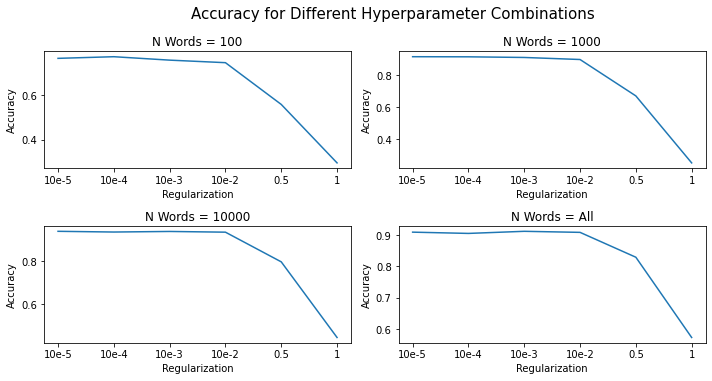

In [56]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))

axs[0,0].plot(accuracies[:6])
axs[0,0].set_title('N Words = 100')
axs[0,0].set(xlabel='Regularization')
axs[0,0].set(ylabel='Accuracy')
axs[0,0].set_xticklabels(['10e-5', '10e-5', '10e-4', '10e-3', '10e-2', '0.5', '1'])

axs[0,1].plot(accuracies[6:12])
axs[0,1].set_title('N Words = 1000')
axs[0,1].set(xlabel='Regularization')
axs[0,1].set(ylabel='Accuracy')
axs[0,1].set_xticklabels(['10e-5', '10e-5', '10e-4', '10e-3', '10e-2', '0.5', '1'])

axs[1,0].plot(accuracies[12:18])
axs[1,0].set_title('N Words = 10000')
axs[1,0].set(xlabel='Regularization')
axs[1,0].set(ylabel='Accuracy')
axs[1,0].set_xticklabels(['10e-5', '10e-5', '10e-4', '10e-3', '10e-2', '0.5', '1'])

axs[1,1].plot(accuracies[18:])
axs[1,1].set_title('N Words = All')
axs[1,1].set(xlabel='Regularization')
axs[1,1].set(ylabel='Accuracy')
axs[1,1].set_xticklabels(['10e-5', '10e-5', '10e-4', '10e-3', '10e-2', '0.5', '1'])

plt.tight_layout()
plt.suptitle('Accuracy for Different Hyperparameter Combinations', y = 1.05, x = 0.55, fontsize = 15)
plt.show()

From comparing the results of the 28 runs, a few patterns are clear. First, and unsurprisingly, lower regularization levels result in more accurate fits. This is unsurprising since we are only looking at the training accuracy. (I am unsure how the NMF model could be fit on a training set and evaluated on a validation set). 

The second clear result is that choosing more word features generally increased accuracy, and the best results were when all 35,000 words were used. This also is not too surprising, given that we are looking at training set data. Because of this, I will use all 35,000 words in the final model. 

### Testing the Model on the Test Set
With some sense of how the different hyperparameters affected accuracy on the training set, I will choose a model to make predictions for the test set. First I will simply choose the model with the highest accuracy, that is the one where all words were vectorized and regularization was 10e-5.

In [57]:
tfidf_vectorizer = TfidfVectorizer(max_features=len(corpus), stop_words="english", ngram_range=(1,3))
tfidf = tfidf_vectorizer.fit_transform(test['Text'])

In [58]:
nmf = NMF(n_components=5, random_state=1, beta_loss="kullback-leibler", solver="mu", max_iter=1000, alpha_W=10e-5, alpha_H = 10e-5).fit(tfidf)

In [59]:
W_test = nmf.transform(tfidf_vectorizer.transform(test['Text']))

In [60]:
# Get the predicted labels
test_preds = pd.DataFrame(np.round(W_test,3))
test_preds['yhat'] = np.argmax(test_preds.values, axis = 1)
test_preds.head(20)

,0,1,2,3,4,yhat
0,0.057,0.000,0.000,0.000,0.000,0
1,0.011,0.000,0.004,0.099,0.000,3
2,0.093,0.000,0.000,0.000,0.000,0
3,0.016,0.000,0.064,0.000,0.000,2
4,0.064,0.000,0.000,0.000,0.000,0
5,0.066,0.000,0.000,0.000,0.000,0
6,0.011,0.147,0.000,0.000,0.000,1
7,0.044,0.051,0.000,0.000,0.000,1
8,0.004,0.000,0.000,0.000,0.100,4
9,0.011,0.000,0.074,0.000,0.000,2


Because I do not have access to the true labels, I am going to have to compare the above numeric labels with what it seems like the topics are.

In [ ]:
test[:20]

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...
5,51,lewsey puzzle over disallowed try england s jo...
6,2025,blair blasts tory spending plans tony blair ha...
7,1479,former ni minister scott dies former northern ...
8,27,career honour for actor dicaprio actor leonard...
9,397,tsunami to hit sri lanka banks sri lanka s b...


The following labelling scheme appears to accurately match the first 20 articles.

In [ ]:
test_label = []
for i in test_preds['yhat']:
    if i == 0:
        test_label.append('sport')
    elif i == 1:
        test_label.append('politics')
    elif i == 2:
        test_label.append('business')
    elif i == 3:
        test_label.append('tech')
    elif i == 4:
        test_label.append('entertainment')

In [ ]:
submission = pd.DataFrame({'ArticleId':test['ArticleId'],'Category':test_label})
submission.to_csv('bbc_submission.csv', header=True, index=False)

The model received a score of 0.88435. I think that is quite respectable. :)

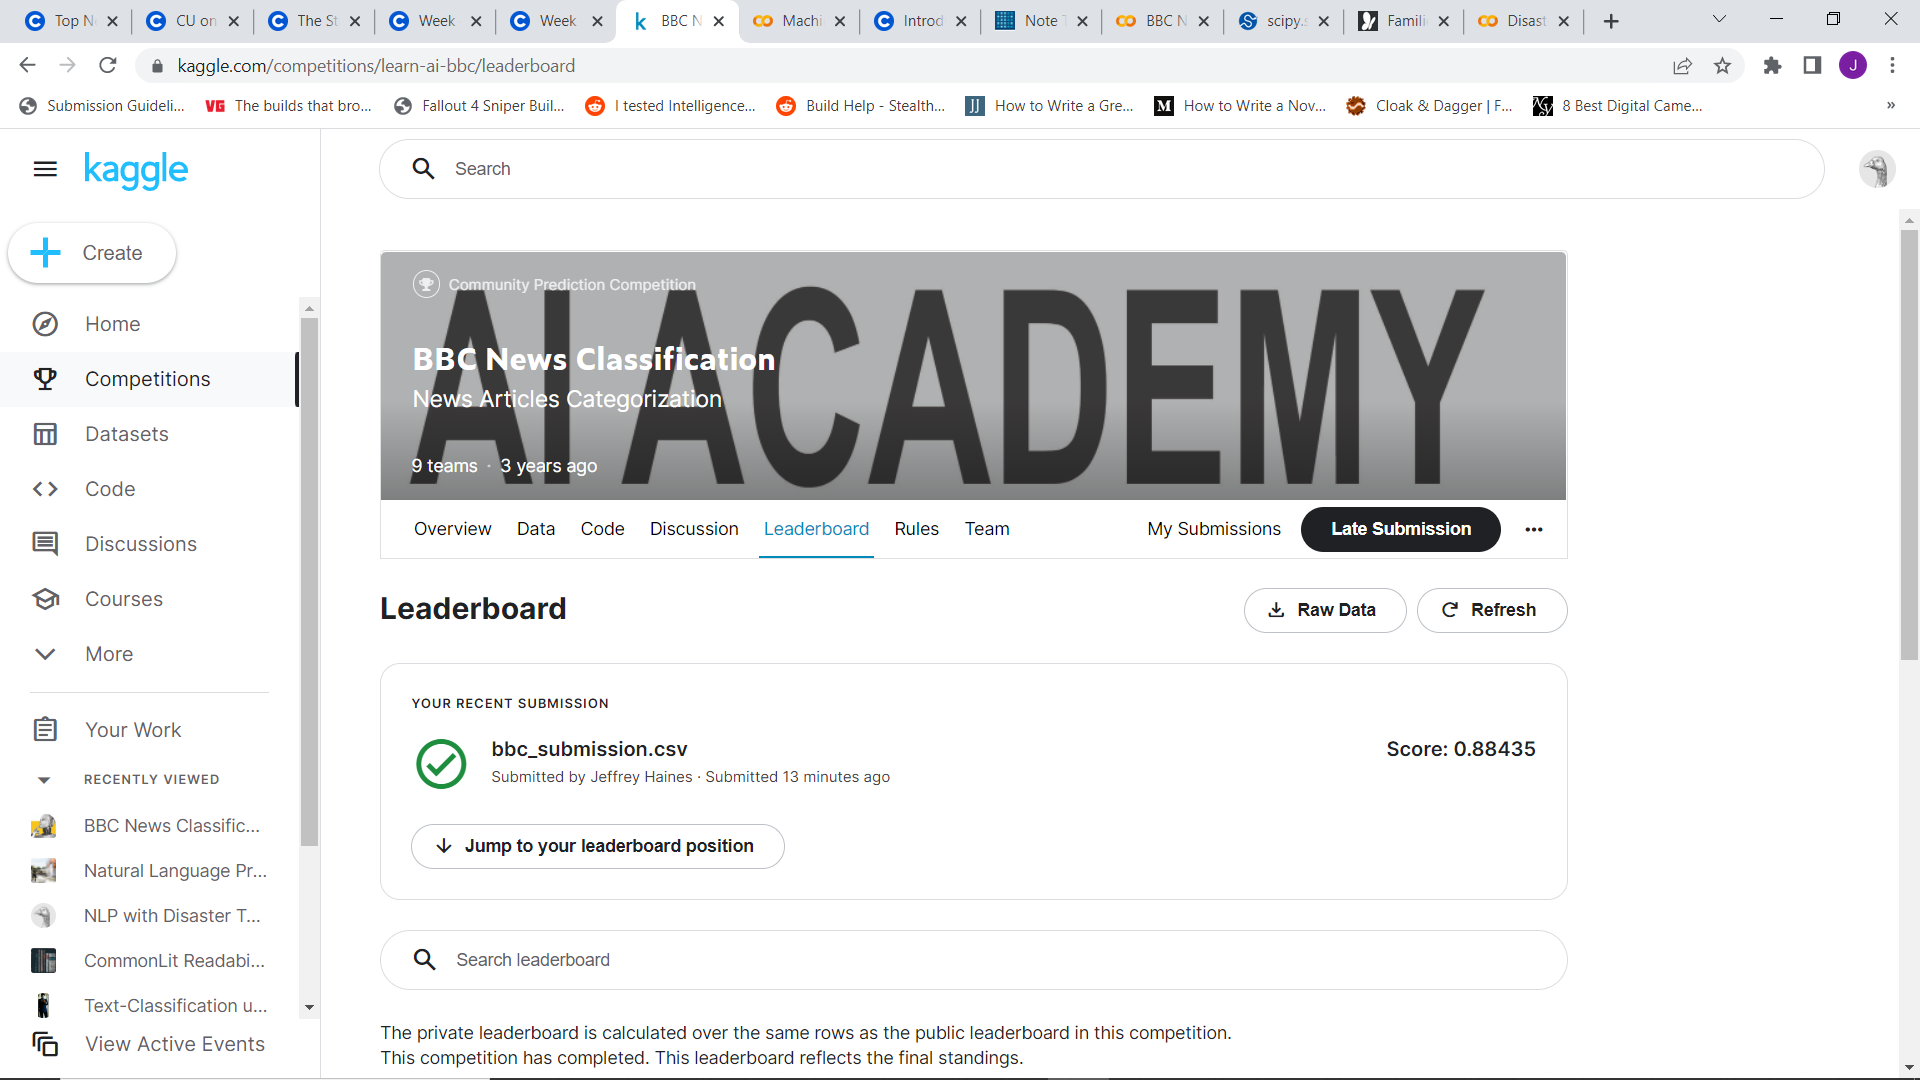

## Compare with Supervised Neural Network
FOr the next part of the project I will compare the matrix factorization method with a supervised learning approach. Since the data is text data, an LSTM model is a natural choice.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.ticker as ticker
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [ ]:
#Split training set into training and validation sets
train_set, val_set = train_test_split(train,test_size = 0.15)

In [ ]:
#set train and test sets and labels
x_train = train_set['Text']
y_train = train_set['Category']

x_val = val_set['Text']
y_val = val_set['Category']

In [ ]:
#set variables
vocab_size = len(corpus)
embedding_dim = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(x_train)  #fit the tokenizer on the train set
word_index = tokenizer.word_index
training_sequence = tokenizer.texts_to_sequences(x_train)
val_sequence = tokenizer.texts_to_sequences(x_val)

I now have to pad the articles to makde them all of the same length. Articles less than that length will get padded with 0's, and articles above that length will get truncated. If you remember, there were a few very long articles. It will take needlessly take up memory to pad every article to have nearly 3,500 words.

If you remember, the average word length for an article was 385 words, and the standard deviation was about 211 words. So let's pad the articles to be one standard deviation above the mean, or 596 words.

In [ ]:
#pad the sentences to make them of the same length
max_length = 596
training_padded = pad_sequences(training_sequence, padding = 'post', maxlen = max_length, truncating = trunc_type)
val_padded = pad_sequences(val_sequence, padding = 'post', maxlen = max_length, truncating = trunc_type)

print("Training shape: ",training_padded.shape)
print("Validation shape: ",val_padded.shape)

Training shape:  (1266, 596)
Validation shape:  (224, 596)


In [ ]:
# Keras requires that I turn the lists into np arrays to feed them into the network.
training_padded = np.array(training_padded)
le = LabelEncoder()
le.fit(y_train)
training_labels = le.transform(y_train)
val_padded = np.array(val_padded)
le.fit(y_val)
val_labels = le.transform(y_val)

In [ ]:
# create the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True)), # define LSTM with # of hidden nodes, feeds back into next layer
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(24, activation = 'relu'),
    tf.keras.layers.Dense(5, activation = 'softmax')
])

In [ ]:
#I compile the model. 
#I use accracy as the metric because this is what I used to evaluate the matrix factorization model
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 596, 16)           569504    
                                                                 
 bidirectional_4 (Bidirectio  (None, 596, 128)         41472     
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 596, 128)          0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 24)               

In [ ]:
num_epochs = 20

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

history = model.fit(training_padded, training_labels, epochs = num_epochs, 
                    validation_data = (val_padded, val_labels), callbacks = [callback], verbose = 2)

Epoch 1/20
40/40 - 25s - loss: 1.5978 - accuracy: 0.2283 - val_loss: 1.6279 - val_accuracy: 0.1920 - 25s/epoch - 628ms/step
Epoch 2/20
40/40 - 18s - loss: 1.3974 - accuracy: 0.3839 - val_loss: 1.2388 - val_accuracy: 0.5223 - 18s/epoch - 442ms/step
Epoch 3/20
40/40 - 17s - loss: 1.0639 - accuracy: 0.5837 - val_loss: 1.0738 - val_accuracy: 0.5670 - 17s/epoch - 436ms/step
Epoch 4/20
40/40 - 18s - loss: 0.7494 - accuracy: 0.6572 - val_loss: 0.7629 - val_accuracy: 0.6429 - 18s/epoch - 440ms/step
Epoch 5/20
40/40 - 18s - loss: 0.5313 - accuracy: 0.7646 - val_loss: 0.7627 - val_accuracy: 0.7143 - 18s/epoch - 440ms/step
Epoch 6/20
40/40 - 17s - loss: 0.4294 - accuracy: 0.8167 - val_loss: 0.6781 - val_accuracy: 0.7634 - 17s/epoch - 436ms/step
Epoch 7/20
40/40 - 17s - loss: 0.3271 - accuracy: 0.8618 - val_loss: 0.7519 - val_accuracy: 0.8304 - 17s/epoch - 434ms/step
Epoch 8/20
40/40 - 18s - loss: 0.2674 - accuracy: 0.9076 - val_loss: 0.7399 - val_accuracy: 0.8527 - 18s/epoch - 440ms/step
Epoch 9/

So far, it appears that the LSTM is performing much the same as the unsupervised approach. Training accuracy is higher with the LSTM, but validation accuracy is about the same as the testing accuracy of the matrix factorization method. Following the suggestion in the project instructions, I train the model on 10%, 20%, and 50% of the training set. I also then train the model on 85% of the training set (a more typical training size). While I do not show all of those training procedures here, below I show the highest validation set accuracy for each amount of training data (after up to 20 epochs). 

In [ ]:
val_acc = [0.3594, 0.5294, 0.4282, 0.8527]
perc_used = ['10%','20%','50%','85%']
pd.DataFrame({'Percent in Training Set':perc_used, 'Highest Val. Accuracy': val_acc}).style.hide_index()

Percent in Training Set,Highest Val. Accuracy
10%,0.359400
20%,0.529400
50%,0.428200
85%,0.852700


Since, as expected, training on 85% of the training set yields the best validation accuracy, I will display those results below. Additionally, it will be the predictions from this model that I submit to Kaggle to get the test accuracy.

In [ ]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

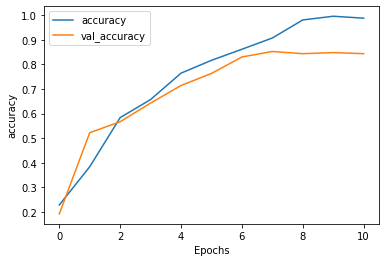

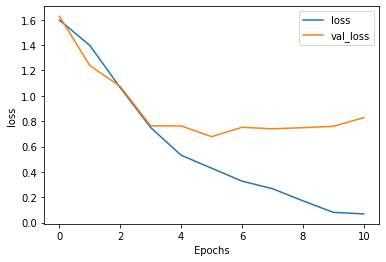

In [ ]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
test_sequences = tokenizer.texts_to_sequences(test['Text'])
test_padded = pad_sequences(test_sequences, maxlen = max_length, padding = 'post')

preds = (model.predict(test_padded))

In [ ]:
preds

array([[9.9396718e-01, 2.3412188e-04, 5.2687244e-07, 1.5695065e-03,
        4.2286185e-03],
       [3.2260828e-02, 4.7176696e-02, 1.6356764e-05, 1.5021418e-04,
        9.2039591e-01],
       [2.5199933e-03, 2.8115528e-05, 1.3379053e-05, 9.9738413e-01,
        5.4353888e-05],
       ...,
       [4.5354959e-02, 2.0162061e-01, 6.8794080e-04, 5.0061935e-04,
        7.5183594e-01],
       [3.1076411e-02, 7.4680060e-02, 5.0528059e-05, 2.0045583e-04,
        8.9399254e-01],
       [1.6796140e-06, 4.6154723e-01, 5.3799736e-01, 2.8645746e-07,
        4.5346882e-04]], dtype=float32)

In [ ]:
yhat = []

for i in preds:
    yhat.append(np.argmax(i))
    
yhat[:20]

[0, 4, 3, 4, 3, 3, 2, 2, 1, 0, 0, 1, 2, 0, 1, 3, 1, 4, 1, 4]

In [ ]:
test['Text'][:20]

0     qpr keeper day heads for preston queens park r...
1     software watching while you work software that...
2     d arcy injury adds to ireland woe gordon d arc...
3     india s reliance family feud heats up the ongo...
4     boro suffer morrison injury blow middlesbrough...
5     lewsey puzzle over disallowed try england s jo...
6     blair blasts tory spending plans tony blair ha...
7     former ni minister scott dies former northern ...
8     career honour for actor dicaprio actor leonard...
9     tsunami  to hit sri lanka banks  sri lanka s b...
10    us economy still growing says fed most areas o...
11    digital uk driven by net and tv the uk s adopt...
12    blunkett tells of love and pain david blunkett...
13    ibm puts cash behind linux push ibm is spendin...
14    cage film s third week at us top nicolas cage ...
15    souness backs smith for scotland graeme sounes...
16    ukip mep attacked german  empire  a uk indepen...
17    cheaper chip for mobiles a mobile phone ch

The predictions for the supervised model do not seem to be as accurate as the ones for the unsupervised model. Nonetheless, it seems like the following scheme provides the best fit:

In [ ]:
test_label = []
for i in yhat:
    if i == 0:
        test_label.append('business')
    elif i == 1:
        test_label.append('entertainment')
    elif i == 2:
        test_label.append('politics')
    elif i == 3:
        test_label.append('sport')
    elif i == 4:
        test_label.append('tech')

In [ ]:
submission = pd.DataFrame({'ArticleId':test['ArticleId'],'Category':test_label})
submission.to_csv('bbc_supervised_submission.csv', header=True, index=False)

The score for the supervisedmodel was not as good: 0.76870.

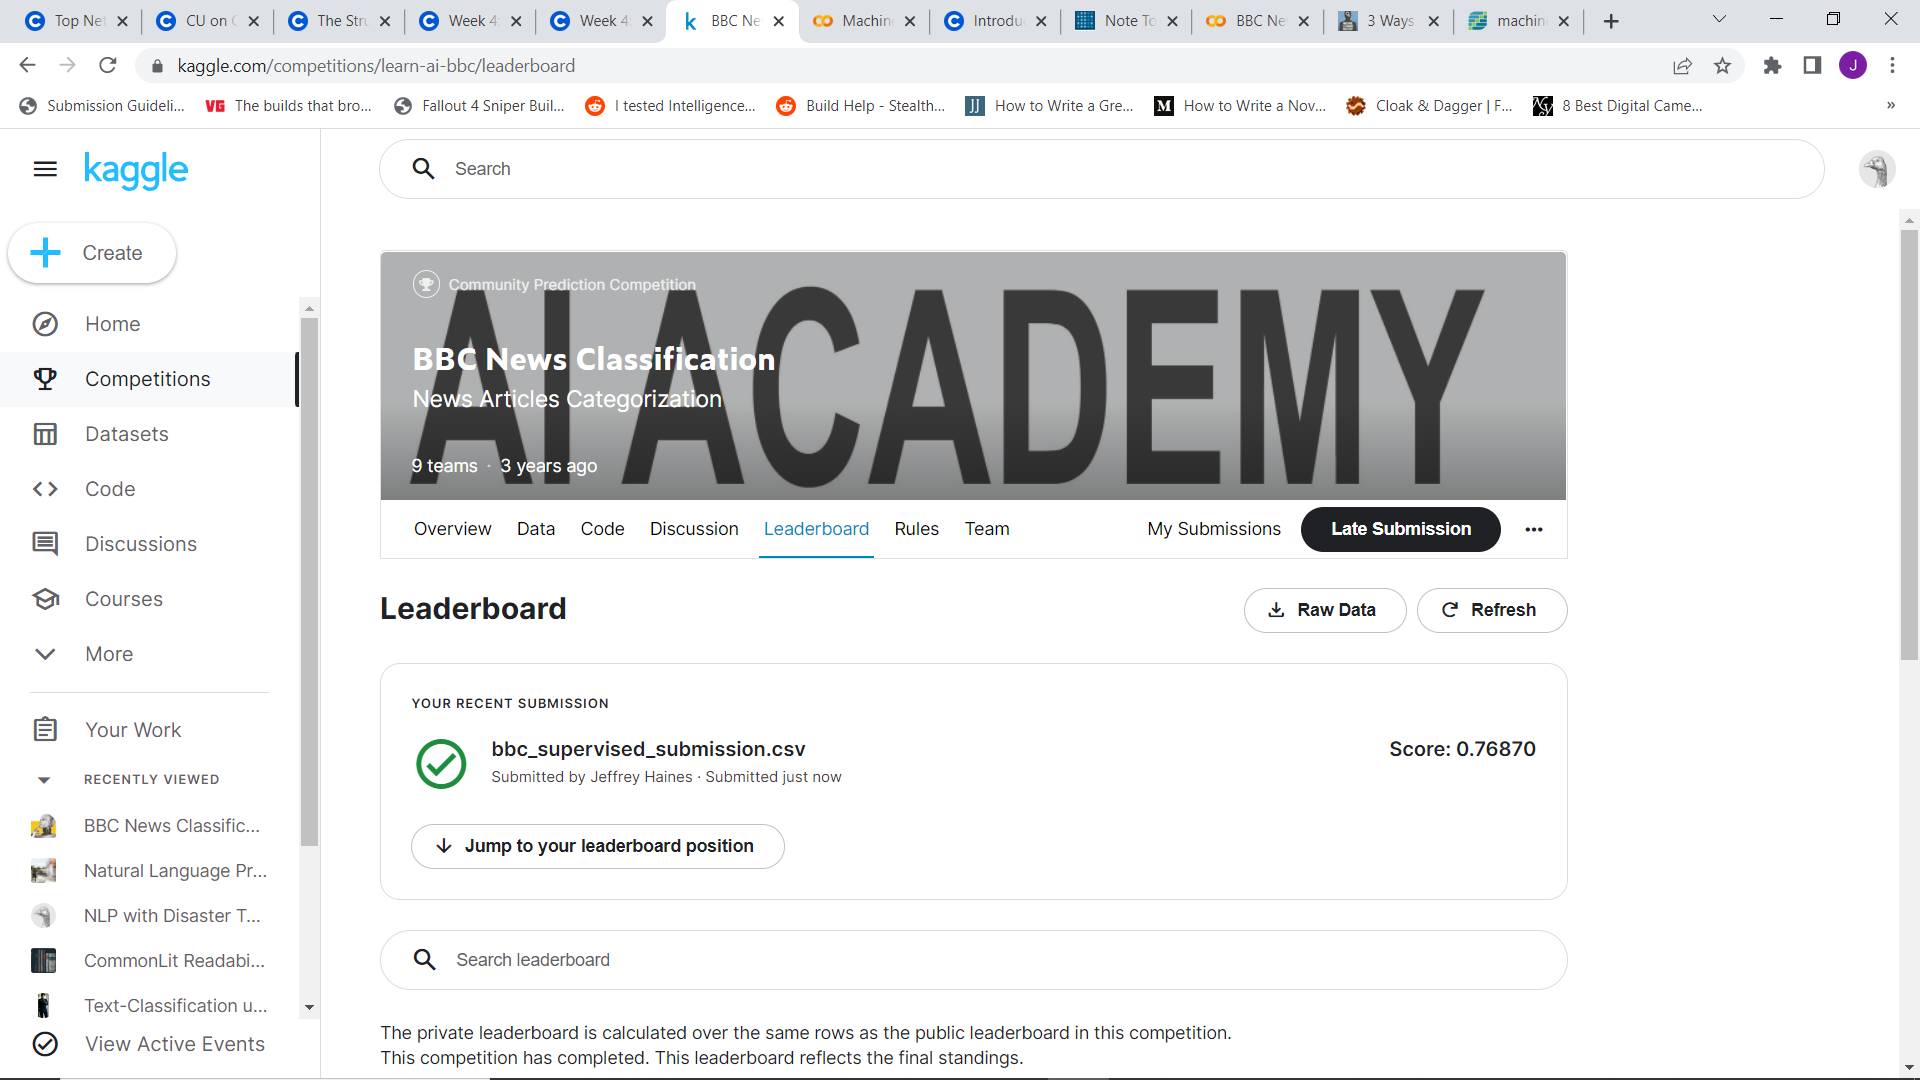

## References
[1] https://datascience.stackexchange.com/questions/25581/what-is-the-difference-between-countvectorizer-token-counts-and-tfidftransformer \
[2] https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html \
[3] https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html 